# Basic Example: Train a MOFA model

This notebook shows a simple way to train a MOFA$^1$ model with additional sparsity priors. We use a chronic lymphocytic leukaemia (CLL) data set, which combined ex vivo drug response measurements with somatic mutation status, transcriptome profiling and DNA methylation assays$^2$.

1: Multi-Omics Factor Analysis-a framework for unsupervised integration of multi-omics data sets by Argelaguet, R. et al. (2018)  
2: Drug-perturbation-based stratification of blood cancer by Dietrich et al. (2018) 

In [1]:
import cellij
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

## Load CLL Data

In [2]:
mdata = cellij.Importer().load_CLL()

#### Preprocess data

In [3]:
# Normalize and log transform MRNA counts
sc.pp.normalize_total(mdata["mrna"], target_sum=1e4)
sc.pp.log1p(mdata["mrna"])

## Experiment 1: Run Factor Analysis

In a first experiment, we will just use three views and run the factorization. Each experiment consists of three necessary steps:
1. Create a new model instance:    `cellij.FactorModel(n_factors=10)`
2. Add data to the model:          `model.add_data(adata)`
3. Train the model:                `model.fit()`

To make your life simple, we only require you to specify the number of factors. In Example 2, we will show you how to deviate from the default parameters and customize your model. 


In [4]:
# 1. We create a new Factor Analysis model
model = cellij.FactorModel(n_factors=10)

In [5]:
# 2. We add an AnnData object to the model and provide a name to distinguish it from other modalities we add later
mdata_3mods = mdata.copy()
del mdata_3mods.mod["mutations"]

model.add_data(mdata_3mods)

In [6]:
# 3. We train the model
model.fit(epochs=10000)

Training:  66%|██████▌   | 6602/10000 [04:29<02:18, 24.51epoch/s, decrease=0.00 %, loss=191.19]


## Plot Results

After training, we can inspect all the learned parameters, visualize the loss curve, etc.

#### Plot a heatmap of the weights and factors

To perform downstream analysis, we need to extract the factor loadings and weights from the model.
We can do this by calling the `get_factors()` and `get_weights()` method.
This returns a dictionary with the latent factors for each modality.

In [7]:
weights = model.get_weights(views="all")
factors = model.get_factors(groups="all")

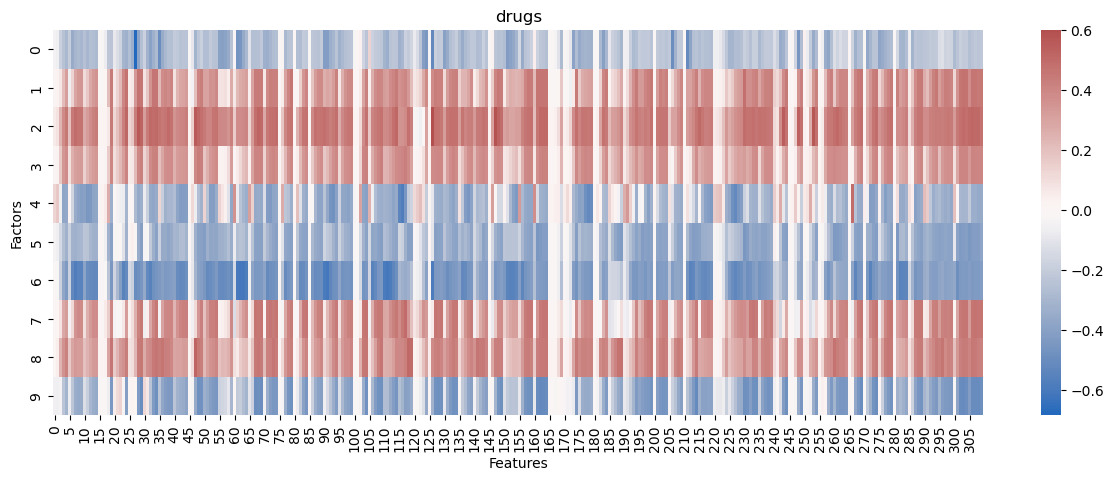

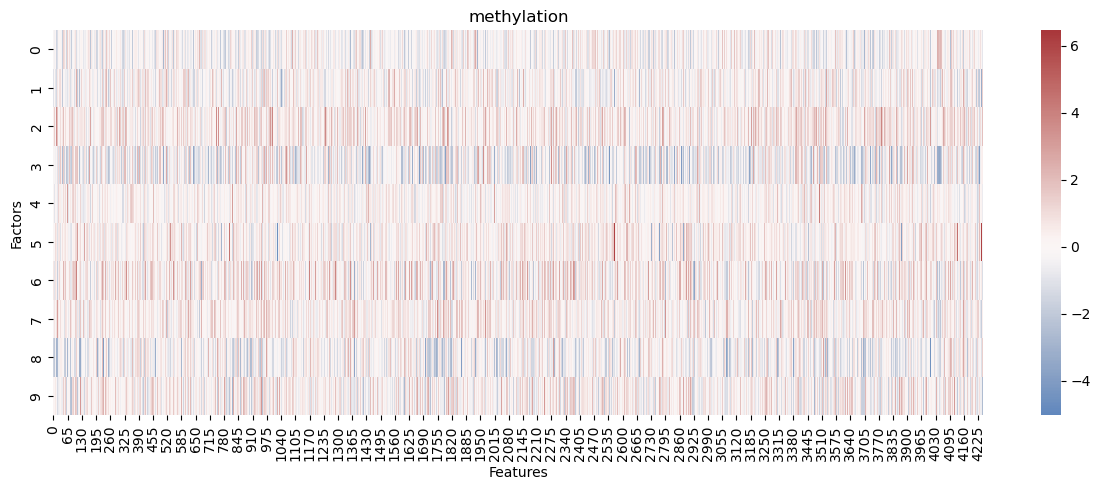

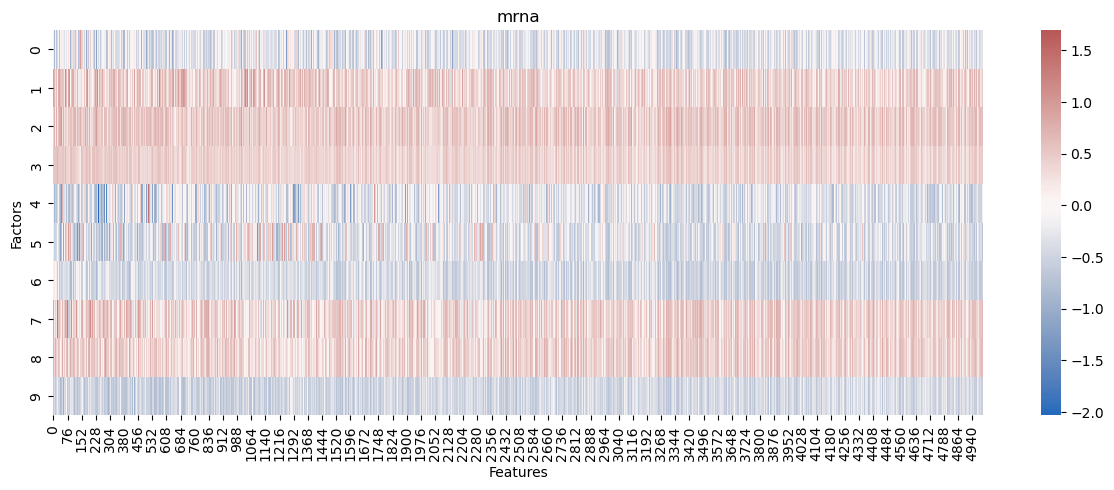

In [8]:
# Let's plot the weights for each modality
for mod, w in weights.items():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.heatmap(w, cmap="vlag", center=0)
    ax.set_title(mod)
    ax.set_ylabel("Factors")
    ax.set_xlabel("Features")
    plt.show()

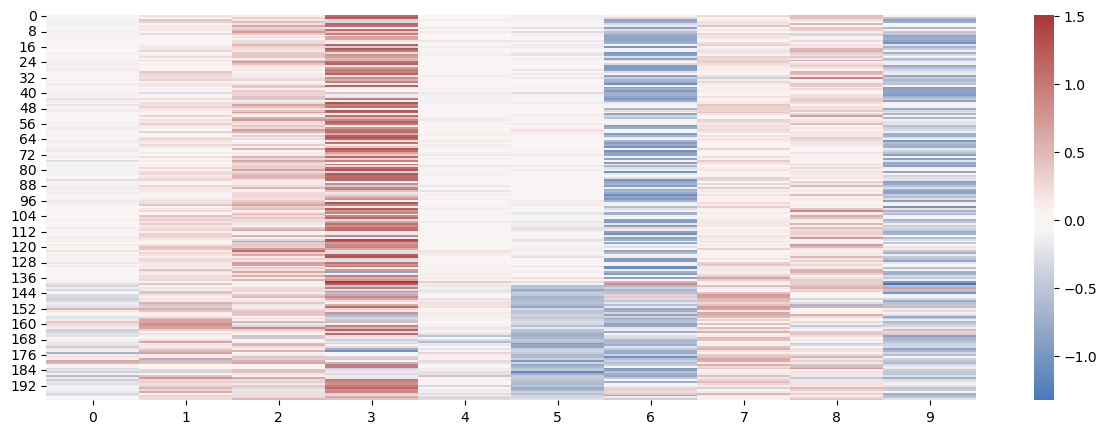

In [9]:
# And our factors
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.heatmap(factors["all_observations"], cmap="vlag", center=0)
plt.show()

#### ELBO

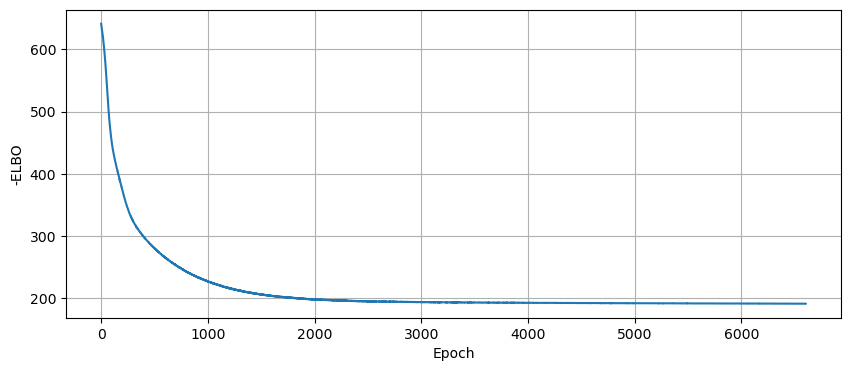

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.plot(model.train_loss_elbo)
plt.xlabel("Epoch")
plt.ylabel("-ELBO")
plt.grid(True)

## Experiment 2: Include Sparsity Priors

Before fitting a model, we can use `set_model_options` to specify various parameters. In the following code, we define the prior we want to place on the views.


In [11]:
model = cellij.FactorModel(n_factors=10)

mdata_3mods = mdata.copy()
del mdata_3mods.mod["mutations"]

model.add_data(mdata_3mods)

model.set_model_options(
    weight_priors={
        "drugs": "Horseshoe",
        "methylation": "Horseshoe",
        "mrna": "Horseshoe",
    },
)

# Retrain the model
model.fit(epochs=10000)

Training:  54%|█████▍    | 5424/10000 [04:22<03:41, 20.66epoch/s, decrease=0.09 %, loss=196.02]


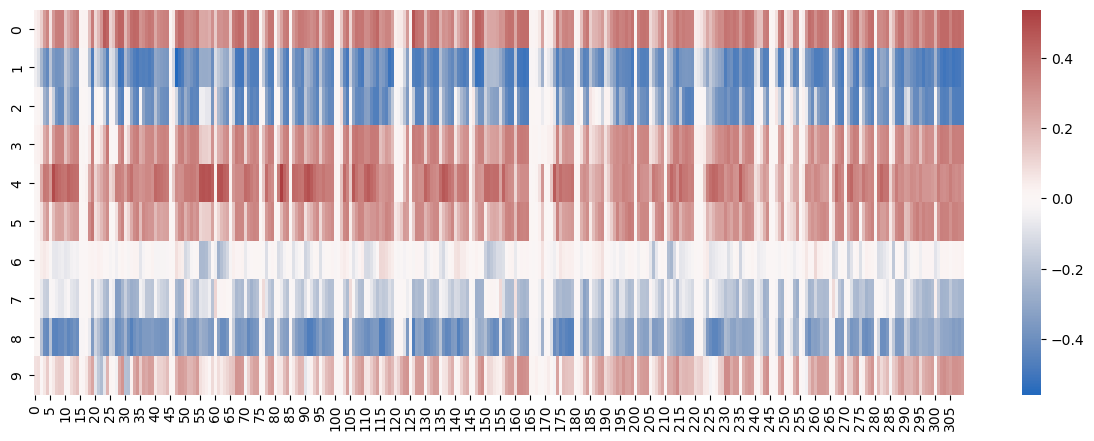

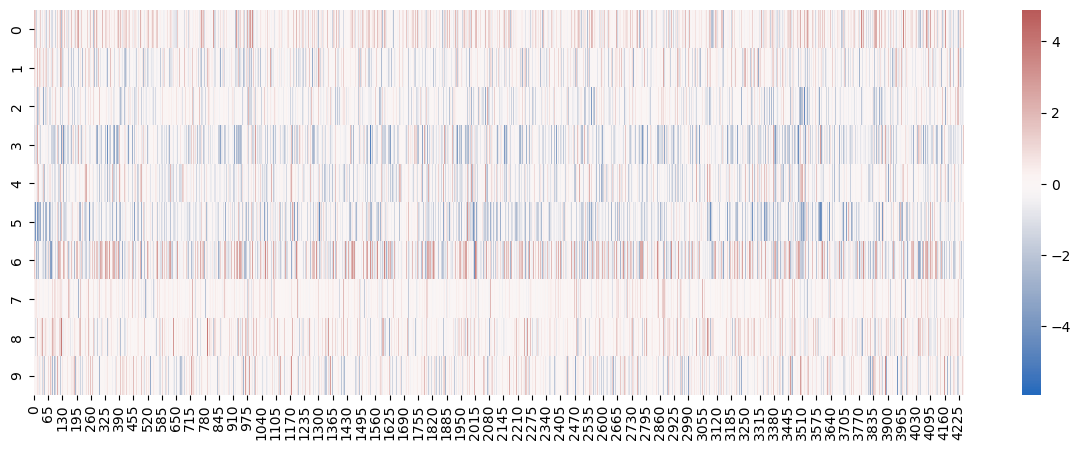

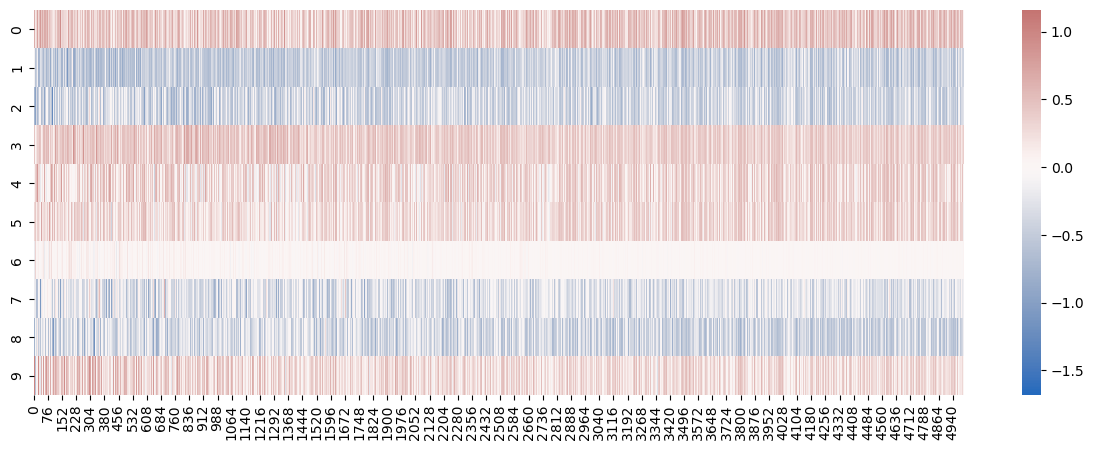

In [12]:
weights = model.get_weights(views="all")

for mod, w in weights.items():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.heatmap(w, cmap="vlag", center=0)
    plt.show()